# 6.Databases and Asynchronous ORMs

**`The main goal of a REST API is, of course, to read and write data.`**

- FastAPI is completely **Database Agnostic**.

## Relational Databases
- Exist since the 1970s
- Proven performance and reliability
- Closely associated with SQL (standard query language)
- Implement the relational model

### Tables and Entities
- Each entity (e.g., users, posts, comments) stored in tables
- Tables have columns representing entity attributes
- Rows represent individual entities

### Relationships
- Core feature of relational databases
- Tables can be related to others
- Rows in one table can refer to rows in other tables

### Primary and Foreign Keys
- Each row has a unique identifier (primary key)
- Foreign keys used to reference rows in other tables
- Avoids data duplication and maintains consistency

### Example: Blog Application Schema
- Tables: Users, Posts, Comments
- Relationships:
  - Post refers to User (user_id foreign key)
  - Comment refers to Post and User (post_id and user_id foreign keys)

### Advantages
- Efficient data retrieval through join queries
- Designed for complex relationships
- Flexible and powerful querying with SQL

### Considerations
- Schema design crucial for performance
- Complex schemas can lead to expensive operations
- Careful query design important for efficiency

### Historical Context
- Standard in database technology for decades
- Proven reliability in various applications

### Query Operations
- Join queries used to retrieve related data
- Efficiency depends on schema complexity and query design

### Best Practices
- Avoid data duplication
- Use foreign keys for relationships
- Design schema carefully to optimize performance
- Consider query complexity when structuring data


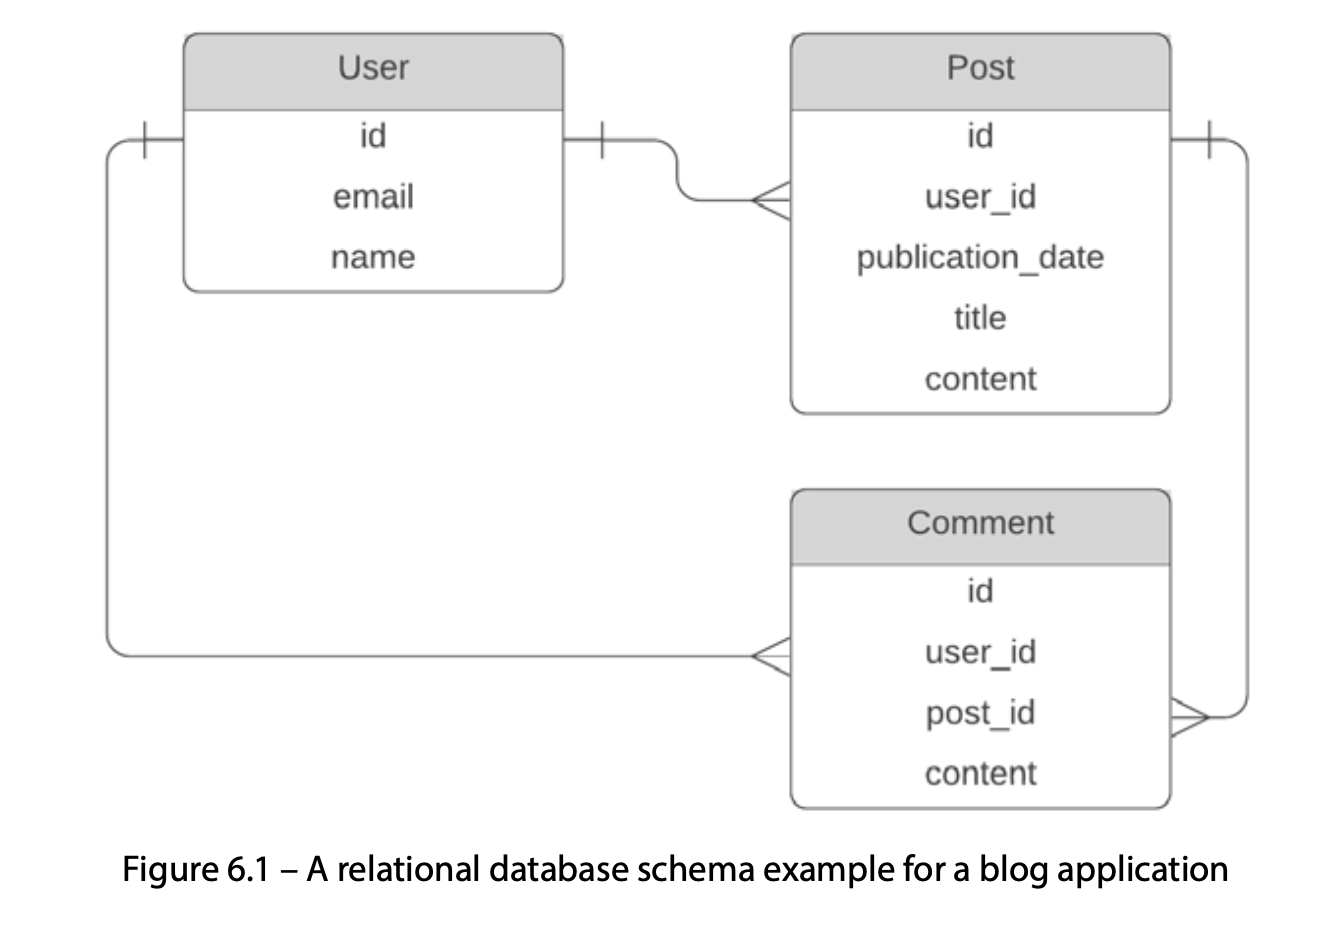

## NoSql Databases

- Encompasses all non-relational database engines
- Includes various types: key-value stores, graph databases, document-oriented databases
- "NoSQL" often implicitly refers to document-oriented databases

## Document-Oriented Databases
- Stores all information of an object in a single document
- Join queries are less common and often more complex
- Documents are stored in collections

### Structure
- Collections (equivalent to tables in relational databases)
- Documents (equivalent to rows)

### Flexibility
- No fixed schema for collections
- Documents in the same collection can have different attributes

### Comparison with Relational Databases

#### Data Organization
- Relational: Data spread across multiple tables
- Document-oriented: All related data in a single document

#### Schema
- Relational: Fixed schema for tables
- Document-oriented: Flexible, schema-less collections

#### Querying
- Relational: Often requires join queries
- Document-oriented: Typically retrieves all data in one query

### Example: Blog Application in Document-Oriented Structure
- Collections: Users, Posts
- Posts collection includes comments as a nested list within each post document

### Advantages
- Improved query performance for certain use cases
- Reduced need for complex join operations
- Suitable for applications with large-scale, less structured data

### Use Cases
- Social networks
- Applications with huge data scales
- Systems with evolving or less rigid data structures

### Historical Context
- Developed to address limitations of relational databases in specific scenarios
- Gained popularity with the rise of big data and web-scale applications

### Best Practices
- Consider data access patterns when designing document structure
- Use nested documents for closely related data (e.g., comments within posts)
- Balance between data duplication and query performance

### Considerations
- May lead to data duplication
- Complex queries across multiple collections can be challenging
- Choosing between relational and NoSQL depends on specific application needs

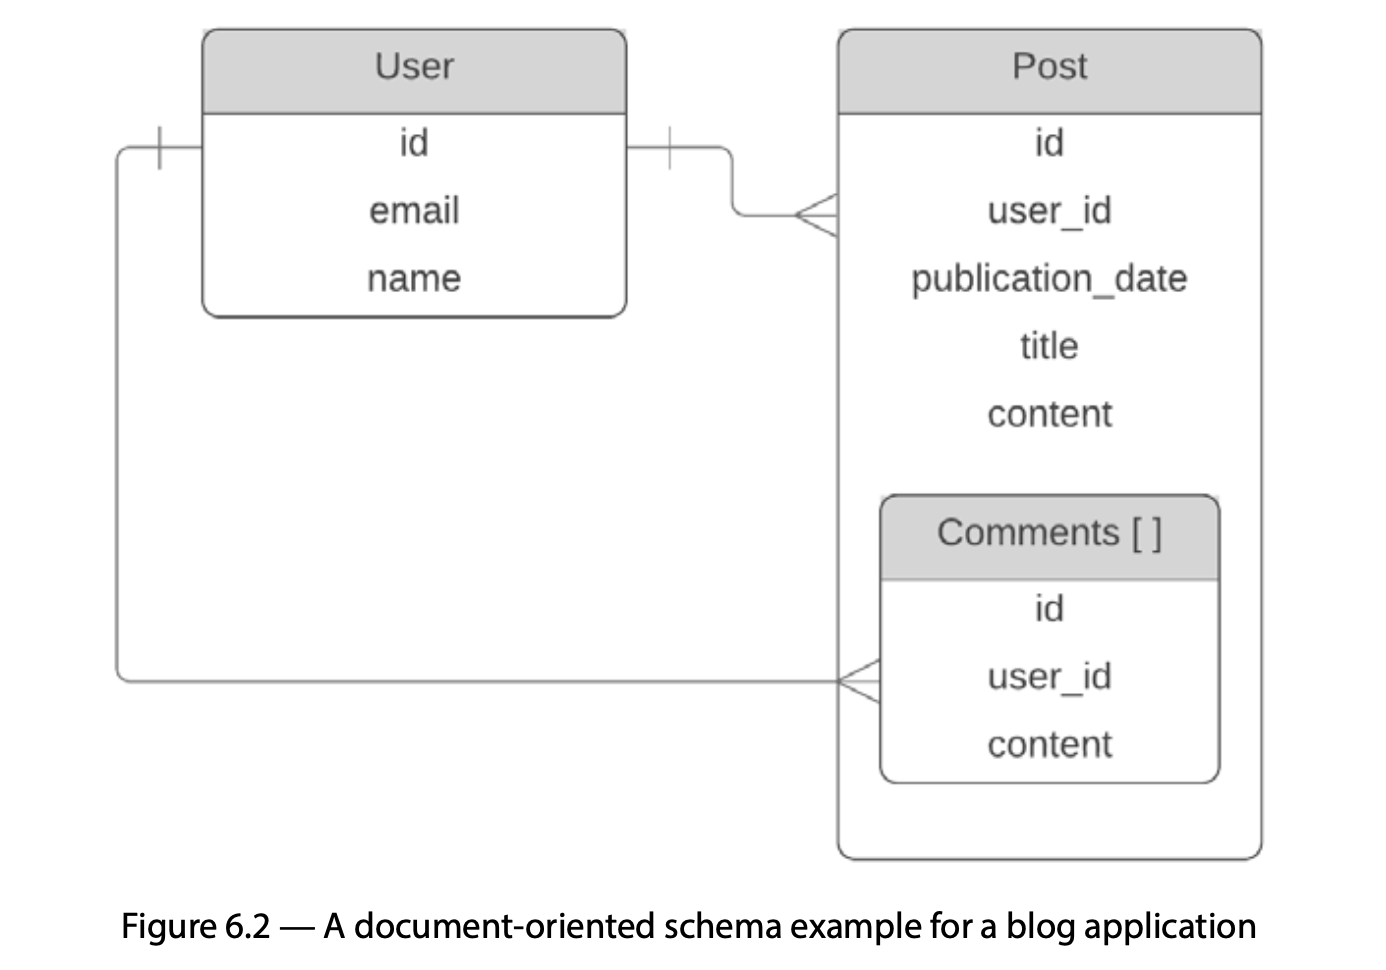

## Communicating with a SQL database with SQLAlchemy ORM

**`SQLAlchemy`** has been around for years and is the most popular library in Python when you wish to work with SQL databases. Since version 1.4, it also **`natively supports async`**. SQLAlchemy is composed of two parts:
- **`SQLAlchemy Core`**: provides all the fundamental features to read and write data to SQL databases.
- **`SQLAlchemy ORM`**: provides a powerful abstraction over SQL concepts.


    ```bash
    $ pip install "sqlalchemy[asyncio,mypy]"
    ```
Notice that we added two optional dependencies: **`asyncio`** and **`mypy`**. The **first one** ensures the tools for async support are installed. The **second one** is a special plugin for mypy that provides special support for SQLAlchemy. ORM does a lot of magic things under the hood, which are hard for type checkers to understand. With this plugin, mypy learns to recognize those constructs.

**`async drivers`** you’ll need to install, depending on your engine:

- **PostgreSQL**
    ```bash
    $ pip install asyncpg
    ```

- **MySQL**
    ```bash
    $ pip install aiomysql
    ```

- **SQLite**
    ```bash
    $ pip install aiosqlite
    ```


### Creating ORM models
**First**, you need to **`define your ORM models`**. Each one is a **Python class** whose **attributes represent the columns** of your table. The actual entities of your database will be instances of this class, giving you access to its data, just like any other object. 
- **`Under the hood, the role of SQLAlchemy ORM is to link this Python object and the row in the database.`**

Let’s take a look at the definition of our blog post model:

In [ ]:
from datetime import datetime

from sqlalchemy import DateTime, Integer, String, Text
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column


class Base(DeclarativeBase):
    pass


class Post(Base):
    __tablename__ = "posts"

    id: Mapped[int] = mapped_column(
        __name_pos=Integer, primary_key=True, autoincrement=True
    )

    publication_date: Mapped[datetime] = mapped_column(
        __name_pos=DateTime, nullable=False, default=datetime.now
    )
    title: Mapped[str] = mapped_column(__name_pos=String(length=255), nullable=False)
    content: Mapped[str] = mapped_column(__name_pos=Text, nullable=False)


```python
from datetime import datetime
```
Imports the `datetime` class from Python's standard library.

```python
from sqlalchemy import DateTime, Integer, String, Text
```
Imports SQLAlchemy types used for defining database column types.

```python
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
```
Imports SQLAlchemy ORM tools for defining models.

```python
class Base(DeclarativeBase):
    pass
```
Defines a base class for declarative class definitions. This is used as a base for all your SQLAlchemy models.

The first step is to create a Base class that inherits from DeclarativeBase. All our models will inherit from this class. Internally, SQLAlchemy uses it to keep all the information about your database schema together. This is why you should create it only once in your whole project and always use the same one throughout.

```python
class Post(Base):
```
Defines a `Post` model that inherits from `Base`.

```python
    __tablename__ = "posts"
```
Specifies the name of the database table for this model.

```python
    id: Mapped[int] = mapped_column(
        __name_pos=Integer, primary_key=True, autoincrement=True
    )
```
Defines an `id` column:
- `Mapped[int]`: Indicates that this attribute maps to an integer in Python.
- `mapped_column`: Function to define column properties.
- `Integer`: SQLAlchemy type for integer columns.
- `primary_key=True`: Makes this column the primary key.
- `autoincrement=True`: Automatically increments the value for new entries.

```python
    publication_date: Mapped[datetime] = mapped_column(
        __name_pos=DateTime, nullable=False, default=datetime.now
    )
```
Defines a `publication_date` column:
- `Mapped[datetime]`: Maps to Python's `datetime` type.
- `DateTime`: SQLAlchemy type for datetime columns.
- `nullable=False`: Column cannot contain NULL values.
- `default=datetime.now`: Sets default value to current date and time.

```python
    title: Mapped[str] = mapped_column(__name_pos=String(length=255), nullable=False)
```
Defines a `title` column:
- `Mapped[str]`: Maps to Python's `str` type.
- `String(length=255)`: SQLAlchemy type for varchar columns with a maximum length of 255 characters.

```python
    content: Mapped[str] = mapped_column(__name_pos=Text, nullable=False)
```
Defines a `content` column:
- `Mapped[str]`: Maps to Python's `str` type.
- `Text`: SQLAlchemy type for text columns (typically used for longer strings).

Differences between Python types and SQLAlchemy types:

1. `str` vs `String` and `Text`:
   - `str`: Python's string type, used in Python code.
   - `String`: SQLAlchemy type for varchar columns, allows specifying length.
   - `Text`: SQLAlchemy type for text columns, typically used for longer strings without length limit.

2. `int` vs `Integer`:
   - `int`: Python's integer type.
   - `Integer`: SQLAlchemy type that maps to the database's integer type.

3. `datetime` vs `DateTime`:
   - `datetime`: Python's datetime type for date and time.
   - `DateTime`: SQLAlchemy type that maps to the database's datetime type.

The `Mapped[]` wrapper is used to indicate the Python type for type checking and ORM functionality, while the SQLAlchemy types (`Integer`, `String`, etc.) define how the data should be stored in the database.

The `__name_pos` parameter in `mapped_column` is used internally by SQLAlchemy for name resolution and shouldn't affect the functionality of your code.

This code defines a `Post` model with an auto-incrementing ID, a publication date, a title (limited to 255 characters), and content (unlimited length). It uses SQLAlchemy's declarative mapping style to create a clear correspondence between Python objects and database tables.